#### This notebook is for mounting POSCAR as an input structure and get trajectory(equivalent to XDATCAR) as .traj file

# pfp and ase mounting

In [2]:
from ase import Atoms
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS, FIRE
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
print(f"pfp_api_client: {pfp_api_client.__version__}")
import numpy as np
import pandas as pd



/home/jovyan/.local/lib/python3.7/site-packages/pfp_api_client/__init__.py:36: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  f"New version of {package_name} is available. Please consider"


pfp_api_client: 1.6.3


# get_opt_energy calculator setting

In [3]:
from ase.optimize import LBFGS
from ase.build import fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter


estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_U0, model_version="v3.0.0")
calculator = ASECalculator(estimator)
def get_opt_energy(atoms, fmax=0.001, opt_mode: str = "normal"):    
    atoms.set_calculator(calculator)
    if opt_mode == "scale":
        opt1 = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]))
    elif opt_mode == "all":
        opt1 = LBFGS(ExpCellFilter(atoms))
    else:
        opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()

## POSCAR reading. put your poscar in the same directory as this ipynb file.

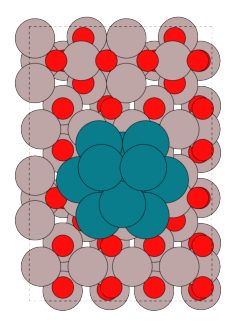

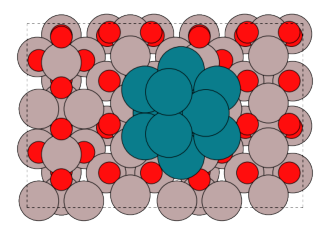

In [9]:
from ase.io import write
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pfcc_extras.visualize.ase import view_ase_atoms
from ase.io.vasp import read_vasp

atoms = read_vasp('POSCAR')
view_ase_atoms(atoms, rotation="0x,0y,0z", figsize=(4, 4), title="", scale=40)
view_ase_atoms(atoms, rotation="0x,0y,90z", figsize=(4, 4), title="", scale=40)


 calculating using pfp functional

In [ ]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from ase.optimize import BFGS, LBFGS, FIRE, MDMin
from ase.io import Trajectory
from pfcc_extras.visualize.view import view_ngl

print(f"pfp_api_client: {pfp_api_client.__version__}")

estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v3.0.0")
calculator = ASECalculator(estimator)
atoms.calc = calculator
traj = Trajectory("./xdatcar.traj", "w", atoms)  # xdatca에
opt2 = LBFGS(atoms)
opt2.attach(traj.write, interval=1)
opt2.run(fmax=0.005)
contcar = Trajectory("./xdatcar.traj")


pfp_api_client: 1.6.3
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 04:40:30    -1012.037372*       3.1276
LBFGS:    1 04:40:31    -1014.688020*       1.7713
LBFGS:    2 04:40:31    -1016.320976*       1.0943
LBFGS:    3 04:40:31    -1016.595243*       0.7910
LBFGS:    4 04:40:31    -1017.038726*       0.3969
LBFGS:    5 04:40:31    -1017.163776*       0.4135
LBFGS:    6 04:40:31    -1017.375147*       0.4305
LBFGS:    7 04:40:31    -1017.486658*       0.4315
LBFGS:    8 04:40:31    -1017.623141*       0.3367
LBFGS:    9 04:40:31    -1017.729182*       0.3145
LBFGS:   10 04:40:31    -1017.820234*       0.3077
LBFGS:   11 04:40:31    -1017.893829*       0.2496
LBFGS:   12 04:40:32    -1017.951141*       0.2197
LBFGS:   13 04:40:32    -1017.996717*       0.2094
LBFGS:   14 04:40:32    -1018.028555*       0.1814
LBFGS:   15 04:40:32    -1018.050568*       0.1469
LBFGS:   16 04:40:32    -1018.069672*       0.1391
LBFGS:   17 

In [14]:
view_ase_atoms(contcar[-1], rotation="0x,0y,0z", figsize=(4, 4), title="", scale=40)

TypeError: 'TrajectoryWriter' object is not subscriptable

# From here on GA calulcation example. 

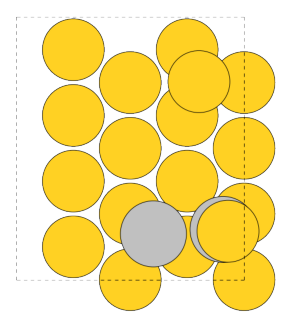

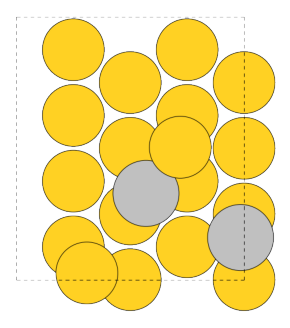

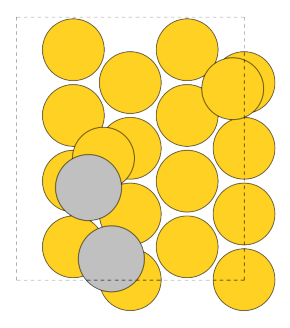

OSError: DB file /home/jovyan/1_Seokhyun/0_tutorials/atomistic-simulation-tutorial/tutorials/en/gadb.db already exists

In [10]:
from ase.ga.data import PrepareDB
from ase.ga.startgenerator import StartGenerator
from ase.ga.utilities import closest_distances_generator
from ase.ga.utilities import get_all_atom_types
from ase.constraints import FixAtoms
import numpy as np
from ase.build import fcc111
from ase.visualize import view   # uncomment these lines

db_file = 'gadb.db'

# create the surface
slab = fcc111('Au', size=(4, 4, 1), vacuum=10.0, orthogonal=True)
slab.set_constraint(FixAtoms(mask=len(slab) * [True]))

# define the volume in which the adsorbed cluster is optimized
# the volume is defined by a corner position (p0)
# and three spanning vectors (v1, v2, v3)
pos = slab.get_positions()
cell = slab.get_cell()
p0 = np.array([0., 0., max(pos[:, 2]) + 2.])
v1 = cell[0, :] * 0.8
v2 = cell[1, :] * 0.8
v3 = cell[2, :]
v3[2] = 3.

# Define the composition of the atoms to optimize
atom_numbers = 2 * [47] + 2 * [79]

# define the closest distance two atoms of a given species can be to each other
unique_atom_types = get_all_atom_types(slab, atom_numbers)
blmin = closest_distances_generator(atom_numbers=unique_atom_types,
                                    ratio_of_covalent_radii=0.7)

# create the starting population
sg = StartGenerator(slab, atom_numbers, blmin,
                    box_to_place_in=[p0, [v1, v2, v3]])

# generate the starting population
population_size = 20
starting_population = [sg.get_new_candidate() for i in range(population_size)]
view_ase_atoms(starting_population[0], rotation="0x,0y,90z", figsize=(4, 4), title="", scale=40)
view_ase_atoms(starting_population[1], rotation="0x,0y,90z", figsize=(4, 4), title="", scale=40)
view_ase_atoms(starting_population[2], rotation="0x,0y,90z", figsize=(4, 4), title="", scale=40)

# create the database to store information in
d = PrepareDB(db_file_name=db_file,
              simulation_cell=slab,
              stoichiometry=atom_numbers)

for a in starting_population:
    d.add_unrelaxed_candidate(a)

In [ ]:
from random import random
from ase.io import write
from ase.optimize import BFGS
from ase.calculators.emt import EMT

from ase.ga.data import DataConnection
from ase.ga.population import Population
from ase.ga.standard_comparators import InteratomicDistanceComparator
from ase.ga.cutandsplicepairing import CutAndSplicePairing
from ase.ga.utilities import closest_distances_generator
from ase.ga.utilities import get_all_atom_types
from ase.ga.offspring_creator import OperationSelector
from ase.ga.standardmutations import MirrorMutation
from ase.ga.standardmutations import RattleMutation
from ase.ga.standardmutations import PermutationMutation
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from ase.optimize import BFGS, LBFGS, FIRE, MDMin
from ase.io import Trajectory
from pfcc_extras.visualize.view import view_ngl

print(f"pfp_api_client: {pfp_api_client.__version__}")

estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v3.0.0")
calculator = ASECalculator(estimator)

# Change the following three parameters to suit your needs
population_size = 20
mutation_probability = 0.3
n_to_test = 20

# Initialize the different components of the GA
da = DataConnection('gadb.db')
atom_numbers_to_optimize = da.get_atom_numbers_to_optimize()
n_to_optimize = len(atom_numbers_to_optimize)
slab = da.get_slab()
all_atom_types = get_all_atom_types(slab, atom_numbers_to_optimize)
blmin = closest_distances_generator(all_atom_types,
                                    ratio_of_covalent_radii=0.7)

comp = InteratomicDistanceComparator(n_top=n_to_optimize,
                                     pair_cor_cum_diff=0.015,
                                     pair_cor_max=0.7,
                                     dE=0.02,
                                     mic=False)

pairing = CutAndSplicePairing(slab, n_to_optimize, blmin)
mutations = OperationSelector([1., 1., 1.],
                              [MirrorMutation(blmin, n_to_optimize),
                               RattleMutation(blmin, n_to_optimize),
                               PermutationMutation(n_to_optimize)])

# Relax all unrelaxed structures (e.g. the starting population)
while da.get_number_of_unrelaxed_candidates() > 0:
    a = da.get_an_unrelaxed_candidate()
    a.calc = calculator
    print('Relaxing starting candidate {0}'.format(a.info['confid']))
    dyn = BFGS(a, trajectory=None, logfile=None)
    dyn.run(fmax=0.05, steps=100)
    a.info['key_value_pairs']['raw_score'] = -a.get_potential_energy()
    da.add_relaxed_step(a)

# create the population
population = Population(data_connection=da,
                        population_size=population_size,
                        comparator=comp)

# test n_to_test new candidates
for i in range(n_to_test):
    print('Now starting configuration number {0}'.format(i))
    a1, a2 = population.get_two_candidates()
    a3, desc = pairing.get_new_individual([a1, a2])
    if a3 is None:
        continue
    da.add_unrelaxed_candidate(a3, description=desc)

    # Check if we want to do a mutation
    if random() < mutation_probability:
        a3_mut, desc = mutations.get_new_individual([a3])
        if a3_mut is not None:
            da.add_unrelaxed_step(a3_mut, desc)
            a3 = a3_mut

    # Relax the new candidate
    a3.calc = EMT()
    dyn = BFGS(a3, trajectory=None, logfile=None)
    dyn.run(fmax=0.05, steps=100)
    a3.info['key_value_pairs']['raw_score'] = -a3.get_potential_energy()
    da.add_relaxed_step(a3)
    population.update()

write('all_candidates.traj', da.get_all_relaxed_candidates())

In [19]:
my2 = Trajectory("./all_candidates.traj")
view_ngl(my2, representations=["ball+stick"])